In [1242]:
import numpy as np
import pandas as pd
#pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn import linear_model
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV

In [1243]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("taeefnajib/used-car-price-prediction-dataset")
path += '/used_cars.csv'
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'used-car-price-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/used-car-price-prediction-dataset/used_cars.csv


# Исследование данных

In [1244]:
df = pd.read_csv(path)

In [1245]:
df.shape

(4009, 12)

In [1246]:
df['price'] = (
    df['price']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

df['milage'] = (
    df['milage']
    .str.replace(' mi.', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

In [1247]:
df.isna().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,170
engine,0
transmission,0
ext_col,0
int_col,0
accident,113


Найдены пропуски только в трех колонках:

*   fuel type
*   accidents
*   clean_title


## Распределение категориальных признаков

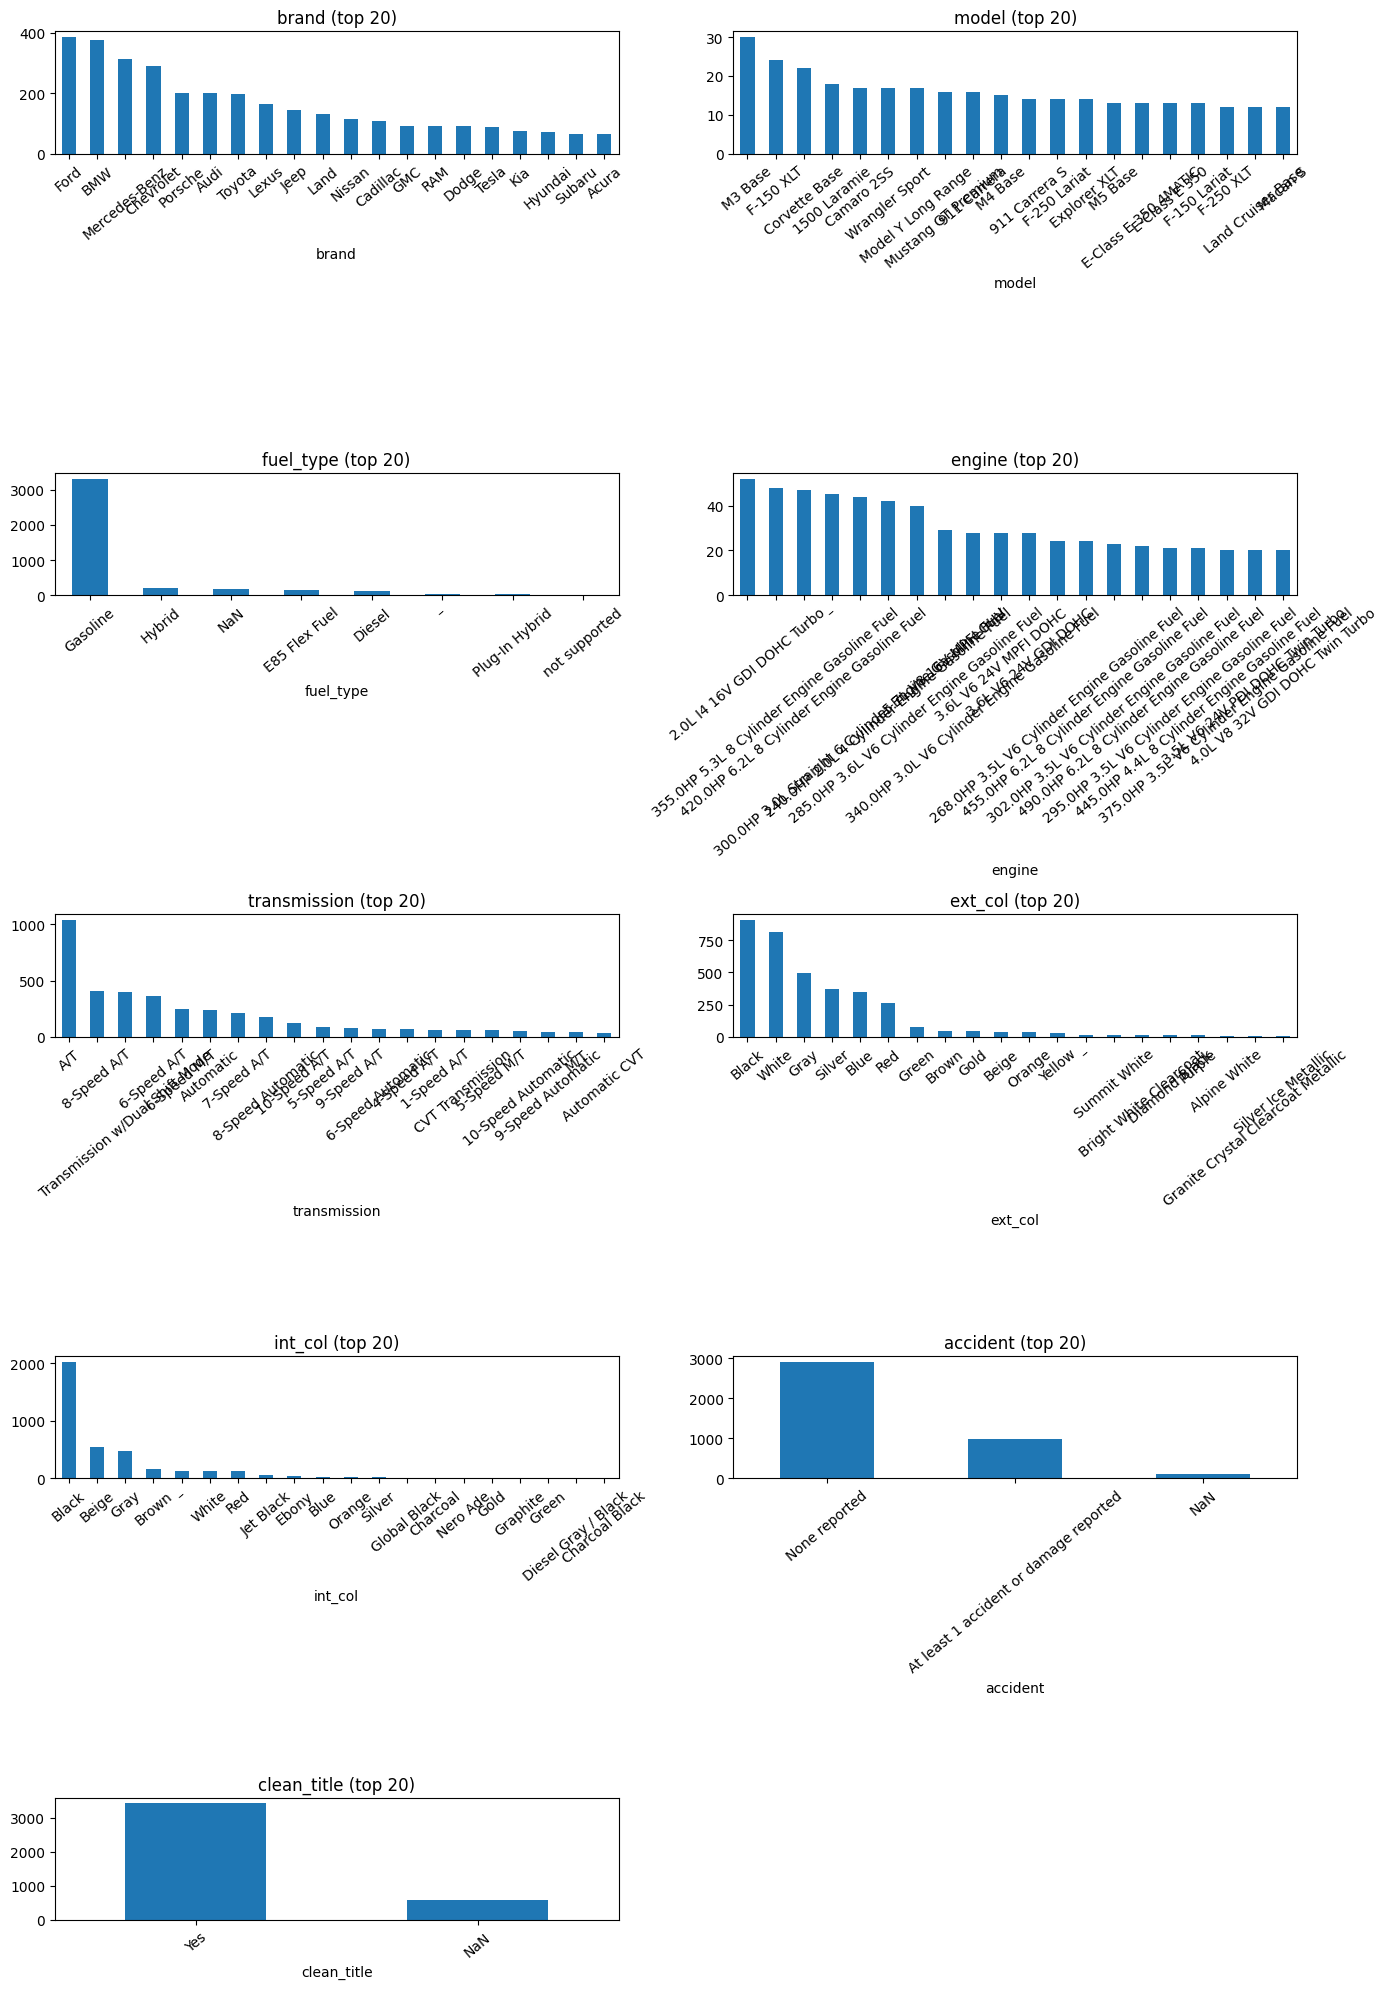

In [1248]:

# 1) берём все категориальные столбцы
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

top_n = 20

ncols = 2
nrows = math.ceil(len(cat_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    vc = df[col].fillna("NaN").value_counts().head(top_n)
    vc.plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"{col} (top {top_n})")
    axes[i].tick_params(axis="x", rotation=40)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Так как несколько категориальных признаков не несут никакой информации и не влияют на цену, предлагаю их удалить, а именно:


*   model
*   ext_col
*   int_col

В них слишком много признаков и у подавляющего большинства выборка из 30-40 машин, так что думаю это больше шум, чем данные. Несмотря на те же характеристики, двигатель можно оставить, так как из большинства можно извлечь horse power, что думаю можно считать существенным признаком. Информацию о коробке передач пока тоже предпочту оставить, потом посмотрю что можно с ней сделать.





In [1249]:
df=df.drop(['model','ext_col','int_col'], axis=1)
df

,brand,model_year,milage,fuel_type,engine,transmission,accident,clean_title,price
0,Ford,2013,51000.00,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,At least 1 accident or damage reported,Yes,10300.00
1,Hyundai,2021,34742.00,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,At least 1 accident or damage reported,Yes,38005.00
2,Lexus,2022,22372.00,Gasoline,3.5 Liter DOHC,Automatic,None reported,NaN,54598.00
3,INFINITI,2015,88900.00,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,None reported,Yes,15500.00
4,Audi,2021,9835.00,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,None reported,NaN,34999.00
...,...,...,...,...,...,...,...,...,...
4004,Bentley,2023,714.00,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,None reported,Yes,349950.00
4005,Audi,2022,10900.00,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,None reported,Yes,53900.00
4006,Porsche,2022,2116.00,NaN,Electric,Automatic,None reported,NaN,90998.00
4007,Ford,2020,33000.00,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,None reported,Yes,62999.00


In [1250]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns
df[cat_cols].nunique()

,0
brand,57
fuel_type,7
engine,1146
transmission,62
accident,2
clean_title,1


In [1251]:
s = df['engine'].astype("string")
hp_str = s.str.extract(r'(?i)\b(\d+(?:\.\d+)?)\s*hp\b', expand=False)
hp_share = hp_str.notna().mean()

print(f"{int(hp_share*100)}%", hp_str.notna().sum())

79% 3201


Как видно, большой процент машин имеет сведения об их hp, так что предлагаю проверить, где будет лучше, если мы оставим 3200 с hp и удалим остальные или если мы просто не станем трогать engine

## водородные
Обе машины с пометкой not supported в топливе - это автомобили на водородном топливе, так что мне кажется, что лучше их удалить, так как это шум.(не уверен, что это можно назвать гипотезой, поэтому просто потом помечу, подтвердилось ли это)

In [1252]:
df[df['fuel_type']== 'not supported']

,brand,model_year,milage,fuel_type,engine,transmission,accident,clean_title,price
2894,Toyota,2021,44000.00,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,None reported,Yes,18500.00
3700,Toyota,2016,40000.00,not supported,151.0HP Electric Motor Hydrogen Fuel,A/T,None reported,Yes,9500.00


## Электрокары
Заметим, что все автомобили с fueltype = Nan - это электрокары.

In [1253]:
df[df['fuel_type'].isna()].head(15)

,brand,model_year,milage,fuel_type,engine,transmission,accident,clean_title,price
9,Tesla,2020,34000.00,NaN,534.0HP Electric Motor Electric Fuel System,A/T,None reported,Yes,69950.00
44,Lucid,2022,3552.00,NaN,536.0HP Electric Motor Electric Fuel System,1-Speed A/T,None reported,Yes,119999.00
68,Lucid,2022,4900.00,NaN,536.0HP Electric Motor Electric Fuel System,1-Speed A/T,None reported,Yes,99000.00
92,Rivian,2023,2800.00,NaN,835.0HP Electric Motor Electric Fuel System,1-Speed A/T,None reported,Yes,92000.00
122,Rivian,2023,2500.00,NaN,835.0HP Electric Motor Electric Fuel System,A/T,None reported,Yes,94000.00
129,Lucid,2023,1300.00,NaN,620.0HP Electric Motor Electric Fuel System,A/T,NaN,NaN,86900.00
155,Tesla,2022,13079.00,NaN,455.0HP Electric Motor Electric Fuel System,A/T,None reported,Yes,47000.00
189,Tesla,2023,500.00,NaN,455.0HP Electric Motor Electric Fuel System,1-Speed A/T,None reported,Yes,60000.00
225,Tesla,2023,8200.00,NaN,670.0HP Electric Motor Electric Fuel System,A/T,None reported,Yes,93999.00
236,Polestar,2021,12172.00,NaN,Electric,1-Speed Automatic,None reported,NaN,35999.00


In [1254]:
df['engine'].str.contains("electric",case=False,na=False).sum()

np.int64(347)

In [1255]:
df["Electric"] = (df["fuel_type"].isna() & df["engine"].str.contains("electric", case=False, na=False)).astype(float)

In [1256]:
df = df.dropna(subset=["fuel_type"])

In [1257]:
df.head(10)

,brand,model_year,milage,fuel_type,engine,transmission,accident,clean_title,price,Electric
0,Ford,2013,51000.00,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,At least 1 accident or damage reported,Yes,10300.00,0.00
1,Hyundai,2021,34742.00,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,At least 1 accident or damage reported,Yes,38005.00,0.00
2,Lexus,2022,22372.00,Gasoline,3.5 Liter DOHC,Automatic,None reported,NaN,54598.00,0.00
3,INFINITI,2015,88900.00,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,None reported,Yes,15500.00,0.00
4,Audi,2021,9835.00,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,None reported,NaN,34999.00,0.00
5,Acura,2016,136397.00,Gasoline,2.4 Liter,F,None reported,NaN,14798.00,0.00
6,Audi,2017,84000.00,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,None reported,Yes,31000.00,0.00
7,BMW,2001,242000.00,Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,None reported,Yes,7300.00,0.00
8,Lexus,2021,23436.00,Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,None reported,Yes,41927.00,0.00
10,Land,2021,27608.00,Gasoline,V6,Automatic,None reported,NaN,73897.00,0.00


In [1258]:
df.isna().sum()

,0
brand,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
accident,109
clean_title,570
price,0
Electric,0


Начнём с исследования вещественный признаков

In [1259]:
df_corr = df.drop(['brand','fuel_type','engine','transmission', 'accident', 'clean_title'], axis=1)

In [1260]:
df_corr.corr()

,model_year,milage,price,Electric
model_year,1.00,-0.61,0.20,NaN
milage,-0.61,1.00,-0.30,NaN
price,0.20,-0.30,1.00,NaN
Electric,NaN,NaN,NaN,NaN


<Axes: >

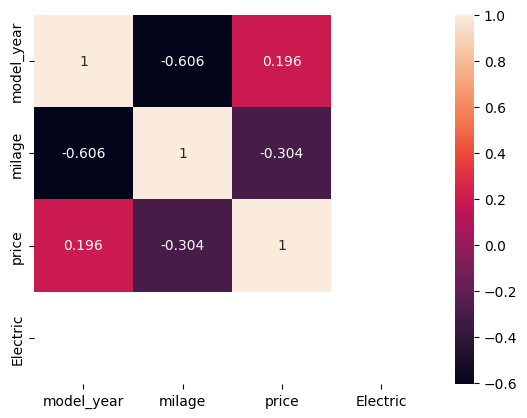

In [1261]:
sns.heatmap(df_corr.corr(),annot = True, fmt = '.3g')

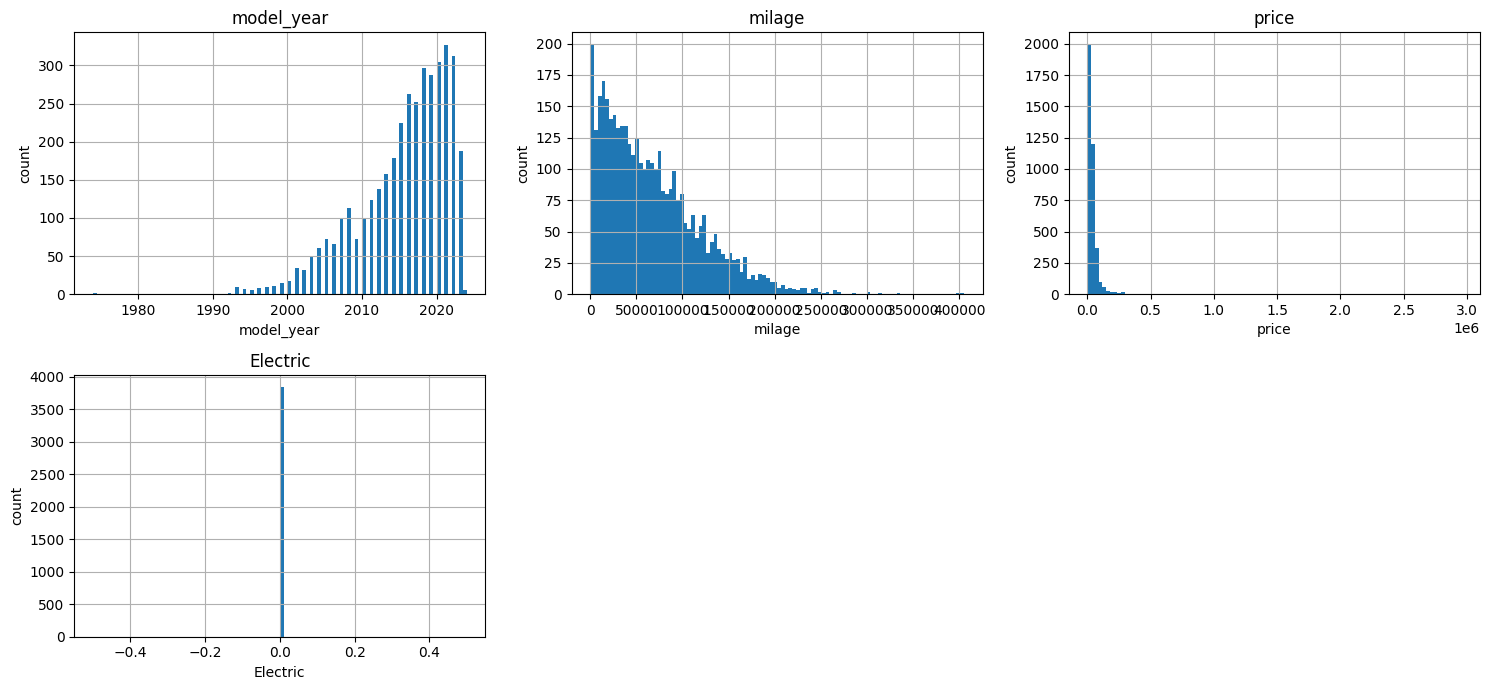

In [1262]:
df_num = df.copy()
numeric_cols = df_num.select_dtypes(include='number').columns.tolist()
n = len(numeric_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.5*n_rows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(numeric_cols):
    df_num[col].dropna().hist(bins=100, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('count')

# скрываем пустые оси
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## clean_title

Как видно из таблицы - Nan в clean_title почти полностью дублирует Nan в accidents, а все остальные значения - это Yes. В связи с этим предполагаю, что столбец не несёт никакой полезной информации и разумнее просто удалить столбец, а также все строки с Nan в accidents, так как их кол-во несущественно.

In [1263]:
df[df['clean_title'].isna()].head(100)

,brand,model_year,milage,fuel_type,engine,transmission,accident,clean_title,price,Electric
2,Lexus,2022,22372.00,Gasoline,3.5 Liter DOHC,Automatic,None reported,NaN,54598.00,0.00
4,Audi,2021,9835.00,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,None reported,NaN,34999.00,0.00
5,Acura,2016,136397.00,Gasoline,2.4 Liter,F,None reported,NaN,14798.00,0.00
10,Land,2021,27608.00,Gasoline,V6,Automatic,None reported,NaN,73897.00,0.00
14,Jaguar,2020,15903.00,Gasoline,2.0 Liter Supercharged,Automatic,None reported,NaN,47998.00,0.00
...,...,...,...,...,...,...,...,...,...,...
413,Land,2020,38356.00,Gasoline,2.0 Liter,Automatic,None reported,NaN,36598.00,0.00
416,Ford,2019,35597.00,E85 Flex Fuel,6.2L V8 16V MPFI SOHC Flexible Fuel,6-Speed Automatic,None reported,NaN,47756.00,0.00
422,Jeep,2022,29800.00,Gasoline,"HEMI 5.7L V-8 variable valve control, regular ...","Automatic, 8-Spd",None reported,NaN,58900.00,0.00
426,Ford,2018,66770.00,E85 Flex Fuel,169.0HP 2.5L 4 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,NaN,NaN,21500.00,0.00


In [1264]:
df = df.drop('clean_title', axis=1)
df = df.dropna(subset='accident')

In [1265]:
df

,brand,model_year,milage,fuel_type,engine,transmission,accident,price,Electric
0,Ford,2013,51000.00,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,At least 1 accident or damage reported,10300.00,0.00
1,Hyundai,2021,34742.00,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,At least 1 accident or damage reported,38005.00,0.00
2,Lexus,2022,22372.00,Gasoline,3.5 Liter DOHC,Automatic,None reported,54598.00,0.00
3,INFINITI,2015,88900.00,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,None reported,15500.00,0.00
4,Audi,2021,9835.00,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,None reported,34999.00,0.00
...,...,...,...,...,...,...,...,...,...
4003,Mercedes-Benz,2018,53705.00,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,At least 1 accident or damage reported,25900.00,0.00
4004,Bentley,2023,714.00,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,None reported,349950.00,0.00
4005,Audi,2022,10900.00,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,None reported,53900.00,0.00
4007,Ford,2020,33000.00,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,None reported,62999.00,0.00


## Коробка передач
Предлаю заменить значения коробки передач на простые Автомат/Ручная

In [1266]:
s = df["transmission"].str.lower()

In [1267]:
df['automatic'] = (s.str.contains("automatic|a/t|cvt|dual|1-speed|overdrive", na=False)).astype(float)

In [1268]:
df[s.str.contains("manual|m/t|bmt|b", na=False)]["transmission"].value_counts().sum()

np.int64(362)

In [1269]:
df.groupby('automatic').size()

,0
automatic,
0.00,376
1.00,3354


In [1270]:
df = df.drop('transmission', axis=1)

In [1271]:
df

,brand,model_year,milage,fuel_type,engine,accident,price,Electric,automatic
0,Ford,2013,51000.00,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,At least 1 accident or damage reported,10300.00,0.00,1.00
1,Hyundai,2021,34742.00,Gasoline,3.8L V6 24V GDI DOHC,At least 1 accident or damage reported,38005.00,0.00,1.00
2,Lexus,2022,22372.00,Gasoline,3.5 Liter DOHC,None reported,54598.00,0.00,1.00
3,INFINITI,2015,88900.00,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,None reported,15500.00,0.00,1.00
4,Audi,2021,9835.00,Gasoline,2.0L I4 16V GDI DOHC Turbo,None reported,34999.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...
4003,Mercedes-Benz,2018,53705.00,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,At least 1 accident or damage reported,25900.00,0.00,1.00
4004,Bentley,2023,714.00,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,None reported,349950.00,0.00,1.00
4005,Audi,2022,10900.00,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,None reported,53900.00,0.00,1.00
4007,Ford,2020,33000.00,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,None reported,62999.00,0.00,1.00


## Horse power(hp)

In [1272]:
df_full = df.copy()


In [1273]:
s = df['engine'].astype("string")
hp_str = s.str.extract(r'(?i)\b(\d+(?:\.\d+)?)\s*hp\b', expand=False)
hp_share = hp_str.notna().mean()

print(f"{int(hp_share*100)}%", hp_str.notna().sum())

80% 2984


In [1274]:
df["hp"] = hp_str.astype(float)
df = df.dropna(subset=["hp"])

In [1275]:
df = df.drop('engine', axis=1)
df_full = df_full.drop('engine', axis=1)

In [1276]:
df.shape

(2984, 9)

In [1277]:
df_full.shape

(3730, 8)

In [1278]:
df.head()

,brand,model_year,milage,fuel_type,accident,price,Electric,automatic,hp
0,Ford,2013,51000.00,E85 Flex Fuel,At least 1 accident or damage reported,10300.00,0.00,1.00,300.00
3,INFINITI,2015,88900.00,Hybrid,None reported,15500.00,0.00,1.00,354.00
6,Audi,2017,84000.00,Gasoline,None reported,31000.00,0.00,1.00,292.00
7,BMW,2001,242000.00,Gasoline,None reported,7300.00,0.00,1.00,282.00
8,Lexus,2021,23436.00,Gasoline,None reported,41927.00,0.00,1.00,311.00


In [1279]:
df_full.head()

,brand,model_year,milage,fuel_type,accident,price,Electric,automatic
0,Ford,2013,51000.00,E85 Flex Fuel,At least 1 accident or damage reported,10300.00,0.00,1.00
1,Hyundai,2021,34742.00,Gasoline,At least 1 accident or damage reported,38005.00,0.00,1.00
2,Lexus,2022,22372.00,Gasoline,None reported,54598.00,0.00,1.00
3,INFINITI,2015,88900.00,Hybrid,None reported,15500.00,0.00,1.00
4,Audi,2021,9835.00,Gasoline,None reported,34999.00,0.00,1.00


In [1280]:
cat_cols = ["brand", "fuel_type", "accident"]
num_cols = ["model_year", "milage", "hp", "Electric", "automatic"]  # что хочешь оставить числом

ohe = OneHotEncoder(sparse_output=True, handle_unknown="ignore")

X_cat = ohe.fit_transform(df[cat_cols])
cat_names = ohe.get_feature_names_out(cat_cols)

X_cat_df = pd.DataFrame.sparse.from_spmatrix(X_cat, columns=cat_names, index=df.index)

X = pd.concat([df[num_cols], X_cat_df], axis=1)

In [1281]:
X

,model_year,milage,hp,Electric,automatic,brand_Acura,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,...,brand_Volvo,brand_smart,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_not supported,accident_At least 1 accident or damage reported,accident_None reported
0,2013,51000.00,300.00,0.00,1.00,0,0,0,0,0,...,0,0,0,1.00,0,0,0,0,1.00,0
3,2015,88900.00,354.00,0.00,1.00,0,0,0,0,0,...,0,0,0,0,0,1.00,0,0,0,1.00
6,2017,84000.00,292.00,0.00,1.00,0,0,0,1.00,0,...,0,0,0,0,1.00,0,0,0,0,1.00
7,2001,242000.00,282.00,0.00,1.00,0,0,0,0,1.00,...,0,0,0,0,1.00,0,0,0,0,1.00
8,2021,23436.00,311.00,0.00,1.00,0,0,0,0,0,...,0,0,0,0,1.00,0,0,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,2023,2000.00,603.00,0.00,1.00,0,0,0,0,0,...,0,0,0,0,0,1.00,0,0,0,1.00
4003,2018,53705.00,241.00,0.00,1.00,0,0,0,0,0,...,0,0,0,0,1.00,0,0,0,1.00,0
4005,2022,10900.00,349.00,0.00,1.00,0,0,0,1.00,0,...,0,0,0,0,1.00,0,0,0,0,1.00
4007,2020,33000.00,450.00,0.00,1.00,0,0,0,0,0,...,0,0,0,0,1.00,0,0,0,0,1.00


In [1282]:
X.filter(like="accident").head()


,accident_At least 1 accident or damage reported,accident_None reported
0,1.00,0
3,0,1.00
6,0,1.00
7,0,1.00
8,0,1.00


In [1283]:
y = df['price']

Подбор гиперпараметров

In [1284]:
print("Best alpha:", grid_ridge.best_params_)
print("Best CV score:", grid_ridge.best_score_)

Best alpha: {'model__alpha': 10}
Best CV score: 0.8284545785753593


In [1285]:

print("Best alpha:", grid_lasso.best_params_)
print("Best CV score:", grid_lasso.best_score_)

Best alpha: {'model__alpha': 0.001}
Best CV score: 0.8286041193244019


# Гипотезы

In [1286]:
y = df['price']

In [1287]:
n_before = len(y)

##Гипотеза 1

Удаление выбросов по цене покажет худший результат, чем логарифмирование целевой переменной

In [1288]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

def cv_r2(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = Ridge(alpha=best_alpha_ridge)
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring="r2")
    return scores.mean()

r2_before = cv_r2(X, y)
r2_before


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


np.float64(0.31586687025491816)

In [1289]:
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

mask = (y >= lower) & (y <= upper)

X_clean = X[mask]
y_clean = y[mask]

In [1290]:
r2_after = cv_r2(X_clean, y_clean)
r2_after

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


np.float64(0.7466694763793462)

In [1291]:
y_log = np.log(y)
r2_log = cv_r2(X, y_log)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [1292]:
print("R2 before:", r2_before)
print("R2 after:", r2_after)
print("Difference:", r2_after - r2_before)
print('R2 log', r2_log)
print("log diff:", r2_log - r2_after)
print('other metrics', others)


R2 before: 0.31586687025491816
R2 after: 0.7466694763793462
Difference: 0.43080260612442806
R2 log 0.8284623967546993
log diff: 0.08179292037535313
other metrics {'MAE': np.float64(0.24680604578360751), 'RMSE': np.float64(0.344984317860969), 'MAPE': np.float64(0.02463338897977644)}


In [1293]:
n_after = len(y_clean)

removed = n_before - n_after
removed_share = removed / n_before

print("Удалено строк:", removed)
print("Доля удалённых:", removed_share)

Удалено строк: 152
Доля удалённых: 0.05093833780160858


Гипотеза подтвердилась, скор действительно вырос после удаления выбросов по цене, причем сильно, но логарифмирование окзалось даже ещё результативнее

Так как логарифмирование показало хороший результат, сделаем его бейзлайном

## Внезапный гридсёрч после проверки гипотез

In [1294]:
y = np.log(df["price"])

In [1295]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_ridge.fit(X, y)




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Ridge())]),
             n_jobs=-1, param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='r2')

In [1296]:
from sklearn.linear_model import Lasso

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(max_iter=10000))
])

param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1]
}

grid_lasso = GridSearchCV(
    pipe_lasso,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_lasso.fit(X, y)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso(max_iter=10000))]),
             n_jobs=-1, param_grid={'model__alpha': [0.001, 0.01, 0.1, 1]},
             scoring='r2')

In [1297]:
best_alpha_ridge = grid_ridge.best_params_['model__alpha']
print(best_alpha_ridge)


10


In [1298]:
best_alpha_lasso = grid_lasso.best_params_['model__alpha']
print(best_alpha_lasso)


0.001


##Гипотеза 2:

 Несмотря на весомую корреляцию, удаление возраста машины или пробега уменьшит R² модели, так как оба признака содержат независимую инф. об автомобиле.

In [1299]:
def train_ridge(X, y):
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import cross_val_score
    import numpy as np

    X = np.asarray(X)

    model = Ridge(alpha=best_alpha_ridge)
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    return np.mean(scores)

r2_full = train_ridge(X.to_numpy(), y)
r2_no_year = train_ridge(X.drop(columns=["model_year"]), y)
r2_no_milage = train_ridge(X.drop(columns=["milage"]), y)


In [1300]:
res = pd.Series({
    "full (year+milage)": r2_full,
    "no model_year": r2_no_year,
    "no milage": r2_no_milage
}).sort_values(ascending=False)

res

,0
full (year+milage),0.82
no model_year,0.77
no milage,0.76


Действительно, после удаления любого из признаков, r2 падает

## Гипотеза 3

Lasso занулит часть категориальных признаков, не ухудшив качество модели.

In [1301]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np

def cv_lasso(X, y, alpha):
    X = np.asarray(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring="r2")
    return scores.mean()

#alphas = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1,0.5,1]
#results = {a: cv_lasso(X, y, a) for a in alphas}

#best_alpha = max(results, key=results.get)

r2_ridge = cv_r2(X, y)
r2_lasso = results[best_alpha]

#print("Best alpha:", best_alpha)
print("Ridge:", r2_ridge)
print("Lasso:", r2_lasso)



Ridge: 0.8284623967546993
Lasso: 0.8286228389162836


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [1302]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.asarray(X))

lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X_scaled, y)

coefs = pd.Series(lasso.coef_, index=X.columns)

zero_count = (coefs == 0).sum()
total = len(coefs)

print("Занулилось:", zero_count)
print("Всего признаков:", total)
print("Доля занулённых:", zero_count / total)


Занулилось: 5
Всего признаков: 64
Доля занулённых: 0.078125


##Гипотеза 4

Если добавить столбец hp вместо engine, то качество модели улучшится, нежели чем если бы мы просто удалили его

In [1303]:
cat_cols = ["brand", "fuel_type", "accident"]
num_cols_full = ["model_year", "milage", "Electric", "automatic"]

ohe_full = OneHotEncoder(sparse_output=True, handle_unknown="ignore", drop="first")

X_cat_full = ohe_full.fit_transform(df_full[cat_cols])
cat_names_full = ohe_full.get_feature_names_out(cat_cols)

X_cat_full_df = pd.DataFrame.sparse.from_spmatrix(
    X_cat_full,
    columns=cat_names_full,
    index=df_full.index
)

X_full = pd.concat([df_full[num_cols_full], X_cat_full_df], axis=1)

y_full = np.log(df_full["price"])



In [1304]:
r2_full = cv_r2(X_full, y_full)
r2_hp = cv_r2(X, y)



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [1305]:
print("Без hp:", r2_full)
print("С hp:", r2_hp)


Без hp: 0.7251877581615063
С hp: 0.8284623967546993


Гипотеза подтверждена, добавление hp ценой части выборки привело к увеличению скора

##Гипотеза 5

 Ridge-регрессия покажет более стабильное качество , чем OLS, из-за наличия коррелирующих признаков (model_year и milage).

In [1306]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score

def cv_stats(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    return scores.mean(), scores.std()

# OLS
ols_mean, ols_std = cv_stats(LinearRegression(), X, y)

# Ridge
ridge_mean, ridge_std = cv_stats(Ridge(alpha=0.5), X, y)




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

In [1307]:
print("OLS mean:", ols_mean)
print("OLS std:", ols_std)
print("Ridge mean:", ridge_mean)
print("Ridge std:", ridge_std)

OLS mean: 0.8284064121640974
OLS std: 0.027991787053645453
Ridge mean: 0.8285811716793748
Ridge std: 0.027453567207861986


##Гипотеза 6

(думаю можно было отнести ко первой гипотезе но я сначала написал,а потом уже подумал об этом)

MAE покажет больший скор из-за наличия выбросов в датафрейме

In [1313]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
import numpy as np

def cv_metrics(X, y_log):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_list = []
    rmse_list = []
    mape_list = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_log.iloc[train_idx], y_log.iloc[test_idx]

        model = Ridge(best_alpha_ridge)
        model.fit(X_train, y_train)

        y_pred_log = model.predict(X_test)

        # возвращаем в исходные цены
        y_pred = np.exp(y_pred_log)
        y_true = np.exp(y_test)

        mae_list.append(mean_absolute_error(y_true, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_true, y_pred)))
        mape_list.append(np.mean(np.abs((y_true - y_pred) / y_true)))

    return {
        "MAE": np.mean(mae_list),
        "RMSE": np.mean(rmse_list),
        "MAPE": np.mean(mape_list)
    }


In [1314]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
def cv_metrics_price(X, y_price, alpha=0.5):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_list, rmse_list, mape_list = [], [], []

    for tr, te in kf.split(X):
        X_train, X_test = X.iloc[tr], X.iloc[te]
        y_train, y_test = y_price.iloc[tr], y_price.iloc[te]

        model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

        # MAPE: защитимся от деления на 0 (на всякий)
        eps = 1e-9
        mape_list.append(np.mean(np.abs((y_test - y_pred) / (y_test + eps))))

    return {
        "MAE": float(np.mean(mae_list)),
        "RMSE": float(np.mean(rmse_list)),
        "MAPE": float(np.mean(mape_list))
    }

In [1315]:

metrics = cv_metrics(X,y)
metrics_clean = cv_metrics_price(X_clean,y_clean)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

In [1316]:
metrics

{'MAE': np.float64(10459.562023124949),
 'RMSE': np.float64(49739.140196679924),
 'MAPE': np.float64(0.25731786518744426)}

In [1317]:
metrics_clean

{'MAE': 7548.1884909884775,
 'RMSE': 10142.896759328496,
 'MAPE': 0.3758384699815548}

После удаления выбросов:

Абсолютные ошибки (MAE и особенно RMSE) существенно снизились, что говорит о лучшей аппроксимации типичных автомобилей.

Однако относительная ошибка (MAPE) выросла, что связано со смещением выборки в сторону более дешёвых автомобилей, где одинаковая ошибка в долларах даёт больший процент отклонения.